In [1]:
import pandas as pd

from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

import numpy as np
import matplotlib.pyplot as plt

import ast


In [2]:

df_made_train = pd.read_csv("datasets/recipes_made_train.csv")
df_made_test = pd.read_csv("datasets/recipes_made_test.csv")
df_made_val = pd.read_csv("datasets/recipes_made_val.csv")
df_raw_interactions = pd.read_csv("datasets/RAW_interactions.csv")
df_raw_recipes = pd.read_csv("datasets/RAW_recipes.csv")
df_pp_users = pd.read_csv("datasets/PP_users.csv")
df_pp_recipes = pd.read_csv("datasets/PP_recipes.csv")
df_train = pd.read_csv("datasets/interactions_train.csv")
df_test = pd.read_csv("datasets/interactions_test.csv")
df_val = pd.read_csv("datasets/interactions_validation.csv")
df_ingr_map = pd.read_csv("datasets/ingr_map.csv")

In [3]:
# Cleaning raw recipe to remove recipes that take longer than 1 day, have more than 25 steps, and more than 40 ingredients
df_rr_clean = df_raw_recipes[df_raw_recipes['minutes'] <= 1440]
df_rr_clean = df_rr_clean[df_rr_clean['n_ingredients'] <= 25]
df_rr_clean = df_rr_clean[df_rr_clean['n_steps'] <= 40]

# Dropping date, u, and i columns
df_train_clean = df_train.drop(["date", "u", "i"], axis=1)
df_test_clean = df_test.drop(["date", "u", "i"], axis=1)
df_val_clean = df_val.drop(["date", "u", "i"], axis=1)

# Removing any recipes that were removed from cleaning the raw recipes
df_train_clean = df_train_clean[df_train_clean['recipe_id'].isin(df_rr_clean['id'])]
df_test_clean = df_test_clean[df_test_clean['recipe_id'].isin(df_rr_clean['id'])]
df_val_clean = df_val_clean[df_val_clean['recipe_id'].isin(df_rr_clean['id'])]

# Removing any recipes that were removed from cleaning the raw recipes
df_made_train = df_made_train[df_made_train['recipe_id'].isin(df_rr_clean['id'])]
df_made_test = df_made_test[df_made_test['recipe_id'].isin(df_rr_clean['id'])]
df_made_val = df_made_val[df_made_val['recipe_id'].isin(df_rr_clean['id'])]


In [4]:
# Normalize content-based features
scaler = StandardScaler()
df_rr_clean['min_normalized'] = scaler.fit_transform(df_rr_clean[['minutes']])
df_rr_clean['n_steps_normalized'] = scaler.fit_transform(df_rr_clean[['n_steps']])
df_rr_clean['n_ingr_normalized'] = scaler.fit_transform(df_rr_clean[['n_ingredients']])

# Convert nutrition strings into a list
df_rr_clean['nutrition'] = df_rr_clean['nutrition'].apply(ast.literal_eval)
    

In [5]:
def convToMap(data, value_cols):
    if isinstance(value_cols, str):
        value_cols = [value_cols]

    for col in ['id'] + value_cols:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    if(len(value_cols) == 1):
        value_map_1 = defaultdict(set)
        for _, row in data.iterrows():
            value_map_1[row['id']].add(row[value_cols[0]])
        return value_map_1
    else:
        value_map_mult = defaultdict(list)
        for _, row in data.iterrows():
            for col in value_cols:
                value_map_mult[row['id']].append(row[col])
        return value_map_mult

In [6]:
id_to_recipe = convToMap(df_rr_clean, ["min_normalized", "nutrition", "n_steps_normalized", "n_ingr_normalized"])

In [7]:

train = defaultdict(list)
for _, data in df_made_train.iterrows():
    recipe = id_to_recipe[data.iloc[1]]
    train['user_id'].append(data.iloc[0])
    train['min_normalized'].append(recipe[0])
    train['calories'].append(recipe[1][0])
    train['total_fat'].append(recipe[1][1])
    train['sugar'].append(recipe[1][2])
    train['sodium'].append(recipe[1][3])
    train['protein'].append(recipe[1][4])
    train['saturated_fat'].append(recipe[1][5])
    train['carbohydrates'].append(recipe[1][6])
    train['n_steps_normalized'].append(recipe[2])
    train['n_ingr_normalized'].append(recipe[3])

X = pd.DataFrame(train)

In [8]:
X.head()

,user_id,min_normalized,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates,n_steps_normalized,n_ingr_normalized
0,2046,0.105265,487.8,16.0,283.0,13.0,52.0,20.0,26.0,-0.648942,0.266937
1,2046,0.843935,368.4,33.0,15.0,35.0,55.0,44.0,5.0,0.955425,2.993820
2,1773,2.101671,756.6,68.0,47.0,115.0,93.0,72.0,13.0,1.668477,1.903067
3,1773,0.604367,163.2,12.0,2.0,11.0,7.0,22.0,5.0,1.490214,-0.278440
4,2046,-0.643387,525.6,69.0,42.0,6.0,8.0,74.0,10.0,0.420636,-0.823816


In [9]:
X.drop(['user_id'], axis=1, inplace=True)
y = df_made_train['made']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

model = LogisticRegression(C=1.0, fit_intercept=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Users\satvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5115103227640608

In [22]:
param_grid = [
    {'penalty':['l1','l2'],
    'C' : [1, 5, 10],
    'solver': ['lbfgs','liblinear'],
}
]

In [23]:
clf = GridSearchCV(model,param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1)
clf

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [1, 5, 10], 'penalty': ['l1', 'l2'],
                          'solver': ['lbfgs', 'liblinear']}],
             verbose=True)

In [24]:
best_clf = clf.fit(X_train,y_train)
best_clf.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\satvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\satvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\satvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packag

LogisticRegression(C=10)

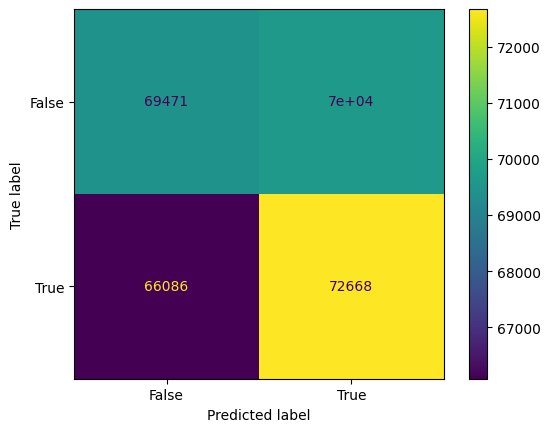

In [53]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


In [57]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


Accuracy: 0.5115103227640608
AUC-ROC: 0.5183909963015025


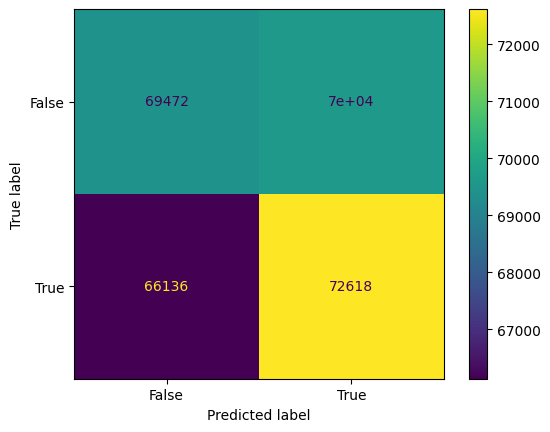

In [25]:
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1]))

Accuracy: 0.5113339882899515
AUC-ROC: 0.5180637499267747
